#### UMAP의 검증에 대하여

[Uniform Manifold Approximation and Projection, UMAP](https://arxiv.org/abs/1802.03426)을 실질적으로 검증하는 *실용적인* 연구는 많지 않습니다. 이 블로그 포스트에서는 실제 예시를 보여주면서, 알고리즘 결과를 검증할 수 있는 추가적인 방법을 제시하고자 합니다.

일반적으로, UMAP의 수렴(convergence)은 다운스트림(후속) 작업을 기준으로 검증하는 것이 보통입니다. 예를 들어 분류(classification) 문제라면, [F1-Score](https://en.wikipedia.org/wiki/F-score)와 같은 객관적인 지표를 사용해 차원 축소 기법이 데이터의 근본적인 구조를 잘 포착했는지를 확인합니다. 그러나, 높은 F1-Score가 **반드시** UMAP이 데이터 구조를 정확하게 포착했다는 것을 보장하지는 않습니다. 다운스트림 작업에서의 높은 정확도는 그저 데이터가 저차원에서 잘 분리된다는 것, 즉 주어진 입력에 대해서 잘 작동한다는 것만을 의미합니다.

간단히 말해, 데이터의 근본적인 구조 유지(구조 보존)를 평가하는 지표 **와** 다운스트림 작업 지표, 이 두 가지를 모두 사용해야 합니다. 이때 전자를 평가하는 방법이 바로 Trustworthiness와 Continuity입니다.

이 블로그 포스트에서는 DenseClus 패키지를 활용해서, UMAP이 안정적인 결과로 수렴했는지를 추가적으로 확인할 수 있는 Trustworthiness와 Continuity 검증 과정을 안내합니다.

#### 그 전에, UMAP이란 무엇인가?

UMAP은 고차원 데이터를 위한 비선형(non-linear) 차원 축소 기법입니다. 시각적으로 t-SNE 알고리즘과 유사하지만, 이를 능가하는 면도 있습니다. UMAP은 데이터가 [locally connected](https://en.wikipedia.org/wiki/Locally_connected) [Riemannian manifold](https://en.wikipedia.org/wiki/Riemannian_manifold) 위에 균일하게 분포한다는 가정과, [Riemannian metric](https://en.wikipedia.org/wiki/Riemannian_metric)이 국소적으로 상수이거나 대략 상수라는 가정 위에 동작합니다(참고: [UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction — umap 0.3 documentation"](https://umap-learn.readthedocs.io/en/latest/)).

[UMAP 논문](https://arxiv.org/abs/1802.03426) (UMAP: Uniform Manifold Approximation and Projection, McInnes 등, 2018)에는 위상수학(Topology) 박사 수준이 되어야 완전히 이해할 수 있는 수학적 증명들이 포함되어 있습니다.

여기서는, **이웃(neighbor) 기반**의 차원 축소 방법으로, 수치형(numeric) 데이터나 범주형(categorical) 데이터 모두 처리할 수 있다고 정의하겠습니다.

더 깊이 이해하고 싶다면, 위의 UMAP 문서 링크나 저자들이 발표한 PyData 강연을 참고하시기 바랍니다.

#### UMAP 학습시키기(Fitting a UMAP)

어쨌든, 예시를 위해 사용할 데이터를 가져와 보겠습니다.

예시 실행을 위해 [Churn Pipeline](https://github.com/awslabs/aws-customer-churn-pipeline) 저장소에서 데이터를 직접 가져옵니다.

원본 이탈(churn) 데이터셋은 공개되어 있으며, [Discovering Knowledge in Data by Daniel T. Larose](https://www.amazon.com/dp/0470908742/)라는 책에서 언급됩니다. 이 데이터는 저자에 의해 UC Irvine의 머신러닝 데이터셋 저장소에 소속된 것으로 알려져 있습니다.


In [5]:
%pip install --upgrade jupyter -q
%pip install --upgrade ipywidgets -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# To supress deprecation warnings
import logging
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from umap import validation

from denseclus import DenseClus

%matplotlib inline

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc={"figure.figsize": (10, 8)})

SEED = 42
np.random.seed(SEED)  # set the random seed as best we can

data_url = (
    "https://raw.githubusercontent.com/awslabs/aws-customer-churn-pipeline/main/data/churn.txt"
)
df = pd.read_csv(data_url).sample(n=2000, random_state=SEED)
df.drop(["Phone", "Area Code"], axis=1, inplace=True)

df.head(5)

,State,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
1501,MA,179,no,yes,400,1.409432,4,3.848624,2.148317,4,3.410357,2.049151,350,4.864806,5.792277,9,1.664503,7,False.
2586,MA,126,no,no,0,3.816301,2,7.070955,5.420410,9,3.101070,8.989511,250,0.424210,4.142589,5,10.617313,1,False.
2653,OR,52,yes,no,0,4.761451,2,6.575281,3.535719,6,3.770251,5.043752,200,4.594888,6.052541,5,3.918532,4,False.
1055,IA,108,yes,no,0,2.453216,3,1.420443,1.630721,2,6.495909,4.257161,200,3.716117,5.777424,6,4.466928,7,False.
705,NY,68,yes,yes,300,6.681023,2,5.524527,2.336734,0,6.257225,1.104317,100,7.967922,5.668193,5,0.006300,9,True.


이제 데이터셋이 로드되었으니, Amazon의 [DenseClus](https://github.com/awslabs/amazon-denseclus)를 적용해 보겠습니다.
DenseClus는 내부적으로 UMAP과 [HDBSCAN](https://github.com/scikit-learn-contrib/hdbscan)을 실행해서, 혼합형 데이터(mixed type data)에 대해 일관성 있는 그룹을 찾습니다. [자세한 내용은 이 블로그 포스트](https://aws.amazon.com/blogs/opensource/introducing-denseclus-an-open-source-clustering-package-for-mixed-type-data/)를 참고하세요.

실제로 아래 코드에서는 수치형 데이터용 UMAP과 범주형 데이터용 UMAP, 이렇게 두 개의 UMAP 레이어를 학습시키고, 이후 두 결과를 결합합니다. 대부분의 전처리 과정은 내부적으로 자동 처리됩니다.

In [4]:
logging.captureWarnings(True)

hdbscan_params = {"cluster_selection_method": "leaf"}

clf = DenseClus(
    random_state=SEED,
    hdbscan_params=hdbscan_params,
    umap_combine_method="intersection_union_mapper",
)

clf.fit(df)

logging.captureWarnings(False)

Max of 51 is greater than threshold 25
Hashing categorical features


여기서는 결과 재현성을 위해 시드(seed)를 설정하고 있는데, 이로 인해 UMAP이 단일 코어에서 실행됩니다.
하지만 실제 환경에서는 단일 코어로 실행하지 않게 됩니다.
즉, UMAP 알고리즘은 본질적으로 확률적(stochastic)이기 때문에, 실제로는 실행할 때마다 결과가 조금씩 달라질 수 있다는 점을 주의하세요.

In [5]:
clf.numerical_umap_.embedding_

array([[5.8050265, 3.7657692, 7.708228 , 6.4899144, 4.2966475],
       [4.1556163, 4.366504 , 9.242688 , 8.893236 , 5.220174 ],
       [3.0964234, 4.607382 , 9.211343 , 8.545794 , 5.6408916],
       ...,
       [5.2809544, 3.5681815, 7.905439 , 6.4484997, 4.3460736],
       [4.2092094, 5.258155 , 8.72766  , 8.88485  , 5.599841 ],
       [3.7001562, 5.1091003, 8.885847 , 8.415293 , 5.7524776]],
      dtype=float32)

#### Trustworthiness(신뢰도) 작동 방식

Trustworthiness(신뢰도)와 Continuity(연속성)는 차원 축소 이후에도 데이터의 구조가 얼마나 잘 보존되었는지를 측정하는 지표입니다.

여기서, 고차원 공간에서 점 *i*의 거리를 가장 가까운 k개의 이웃과의 순위(rank order)로 측정하고, 이 순위가 저차원 공간에서 어떻게 변하는지 평가합니다. n개의 샘플에 대해, r(i,j)는 고차원 공간에서 샘플 i에서 샘플 j까지의 거리 순위입니다(Uki). 비슷하게, r^(i,j)는 저차원 공간에서의 순위(Vki)입니다. k-최근접 이웃(k-nearest neighbours)을 사용하여, 저차원 공간에서도 이 k개의 이웃이 여전히 점 i 근처에 있다면, 그 맵(embedding)은 신뢰할 수 있다고 봅니다.

비슷하게, Continuity(연속성)는 원래 데이터의 클러스터(데이터 점의 집합)가 얼마나 잘 보존되는지 평가하는데, 이는 신뢰도와 반대되는 개념으로, 저차원 공간에서는 가까이 있지만 고차원 공간에서는 그렇지 않은 점들을 찾아냅니다.

이러한 계산 결과 점수는 0과 1 사이의 값을 가지며, 점수가 높을수록 원본 데이터셋의 지역(local) 구조가 UMAP 임베딩(embedding)에서 잘 보존되었다는 뜻입니다.

UMAP은 (validation 서브모듈에서) Numba로 최적화된 계산법을 제공하기 때문에, 중간 규모의 데이터에도 빠르게 사용할 수 있습니다. [여기](https://github.com/lmcinnes/umap/issues/6)에서도 언급되었고, [SKLearn 라이브러리](https://github.com/scikit-learn/scikit-learn/blob/ccd3331f7eb3468ac96222dc5350e58c58ccba20/sklearn/manifold/t_sne.py#L394)에서도 참조 구현을 볼 수 있습니다.

위에서 설명한 것과 마찬가지로, 원본 데이터와 임베딩 사이의 각 점 K에 대해 pairwise distance(쌍별 거리)를 측정합니다. 만약 예상치 못한 이웃(neighbor)이 발견되면, 원본 데이터에서의 순위(rank)에 비례해서 패널티를 부여합니다.

설명은 여기까지 하고, 이제 실제로 임베딩 결과가 원본 데이터의 이웃들을 잘 잡아냈는지 확인해 보겠습니다.

#### 데이터에 대한 검증 실행

이 예시에서는 K=50으로 설정해서, 50개의 이웃 점들을 비교 대상으로 삼습니다.

*참고: 여기서는 기본값인 유클리드 거리(euclidean distance)를 사용하지만, 다른 pairwise 거리나 제곱 거리(squared distance)도 지원합니다. 궁극적으로는 데이터 특성에 맞게 선택하는 문제입니다.*

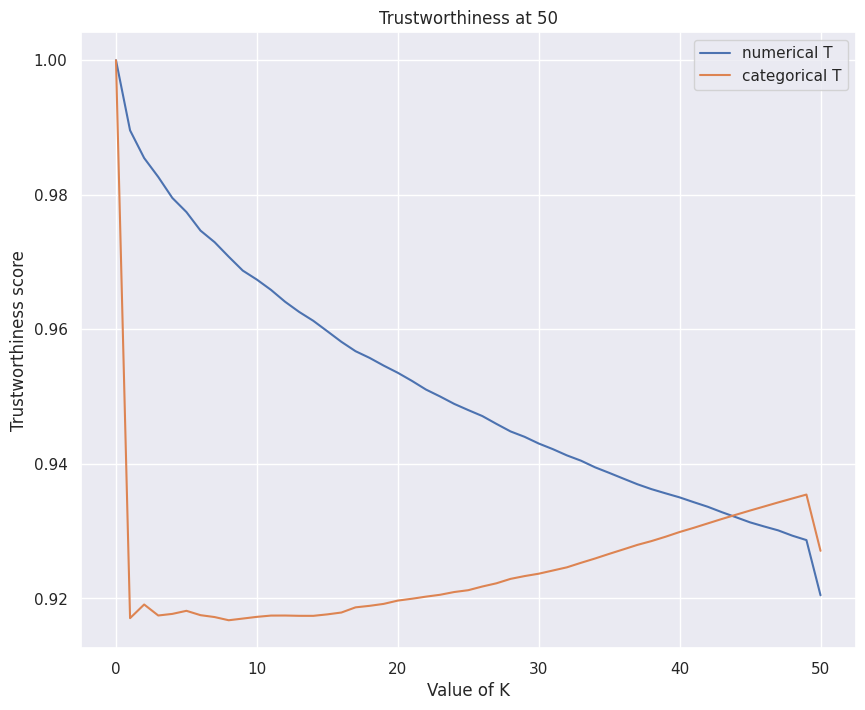

In [8]:
K = 50

# supress numba deprecation warnings from UMAP
filterwarnings("ignore")

numerical_trustworthiness = validation.trustworthiness_vector(
    source=clf.numerical_umap_._raw_data, embedding=clf.numerical_umap_.embedding_, max_k=K
)

categorical_trustworthiness = validation.trustworthiness_vector(
    source=clf.categorical_umap_._raw_data, embedding=clf.categorical_umap_.embedding_, max_k=K
)

filterwarnings("default")


plt.plot(numerical_trustworthiness)
plt.plot(categorical_trustworthiness)
plt.ylabel("Trustworthiness score")
plt.xlabel("Value of K")
plt.title(f"Trustworthiness at {K}")

plt.legend(["numerical T", "categorical T"], loc="upper right")

plt.show()

일반적으로, 신뢰도(Trustworthiness) 점수가 0.80 이상이면 "좋다(good)"고 간주합니다.
점수가 더 낮게 나온다면, 입력 데이터와 UMAP의 파라미터들을 다시 점검해서 더 적합한 설정을 찾아야 합니다.

DenseClus는 기본적으로 K=30의 이웃을 사용해서 UMAP 임베딩을 생성하기 때문에, 여기서의 비교도 공정하다고 볼 수 있습니다.

#### 결론

이번 블로그 포스트에서는, 신뢰도(Trustworthiness) 지표를 사용해서 UMAP 임베딩에서 이웃 점들이 원본 데이터와 임베딩 간에 얼마나 멀리 떨어졌는지를 확인하는 방법을 배웠습니다.

[DenseClus](https://aws.amazon.com/blogs/opensource/introducing-denseclus-an-open-source-clustering-package-for-mixed-type-data/)는 여러 임베딩 결과를 이렇게 검증하는 과정을 쉽게 시연할 수 있게 해줍니다. 실제로 DenseClus는 두 임베딩을 결합해서 제3의 임베딩 공간을 만들고, 이 공간에서 클러스터를 계산합니다! 단, 이 공간은 UMAP 그래프들 간의 집합 연산으로 생성되는 것이기 때문에 비교할 수 있는 원본 데이터가 존재하지 않습니다. 여기서 추가적으로 성공 여부를 검증하려면, 다운스트림 작업을 수행하는 것이 가장 좋은 방법입니다.

다음 블로그 포스트에서 이 주제를 다룰 예정입니다.

여기까지 읽어주셔서 감사합니다 :)

여기서 소개한 내용은 빙산의 일각에 불과하다는 점을 기억하세요. Trustworthiness를 제약조건으로 두고, 다운스트림 작업 방식에 맞춰 여러 하이퍼파라미터를 조정(tuning)하는 것도 가능합니다.

이 예시에서 사용한 노트북은 DenseClus의 Github 저장소 [여기](https://github.com/awslabs/amazon-denseclus/tree/main/notebooks/Validating_UMAP_Example.ipynb)에 게시되어 있습니다.

### References

*"Uniform manifold approximation and projection for dimension reduction"*, McInnes, Leland; Healy, John; Melville, James 2018

*“Neighborhood Preservation in Nonlinear Projection Methods: An Experimental Study”*, Venna 2001

*“Semantically Controlled Adaptive Equalisation in Reduced Dimensionality Parameter Space“*, Stasis et al 2016